# **LLaMA 3 From Scratch**

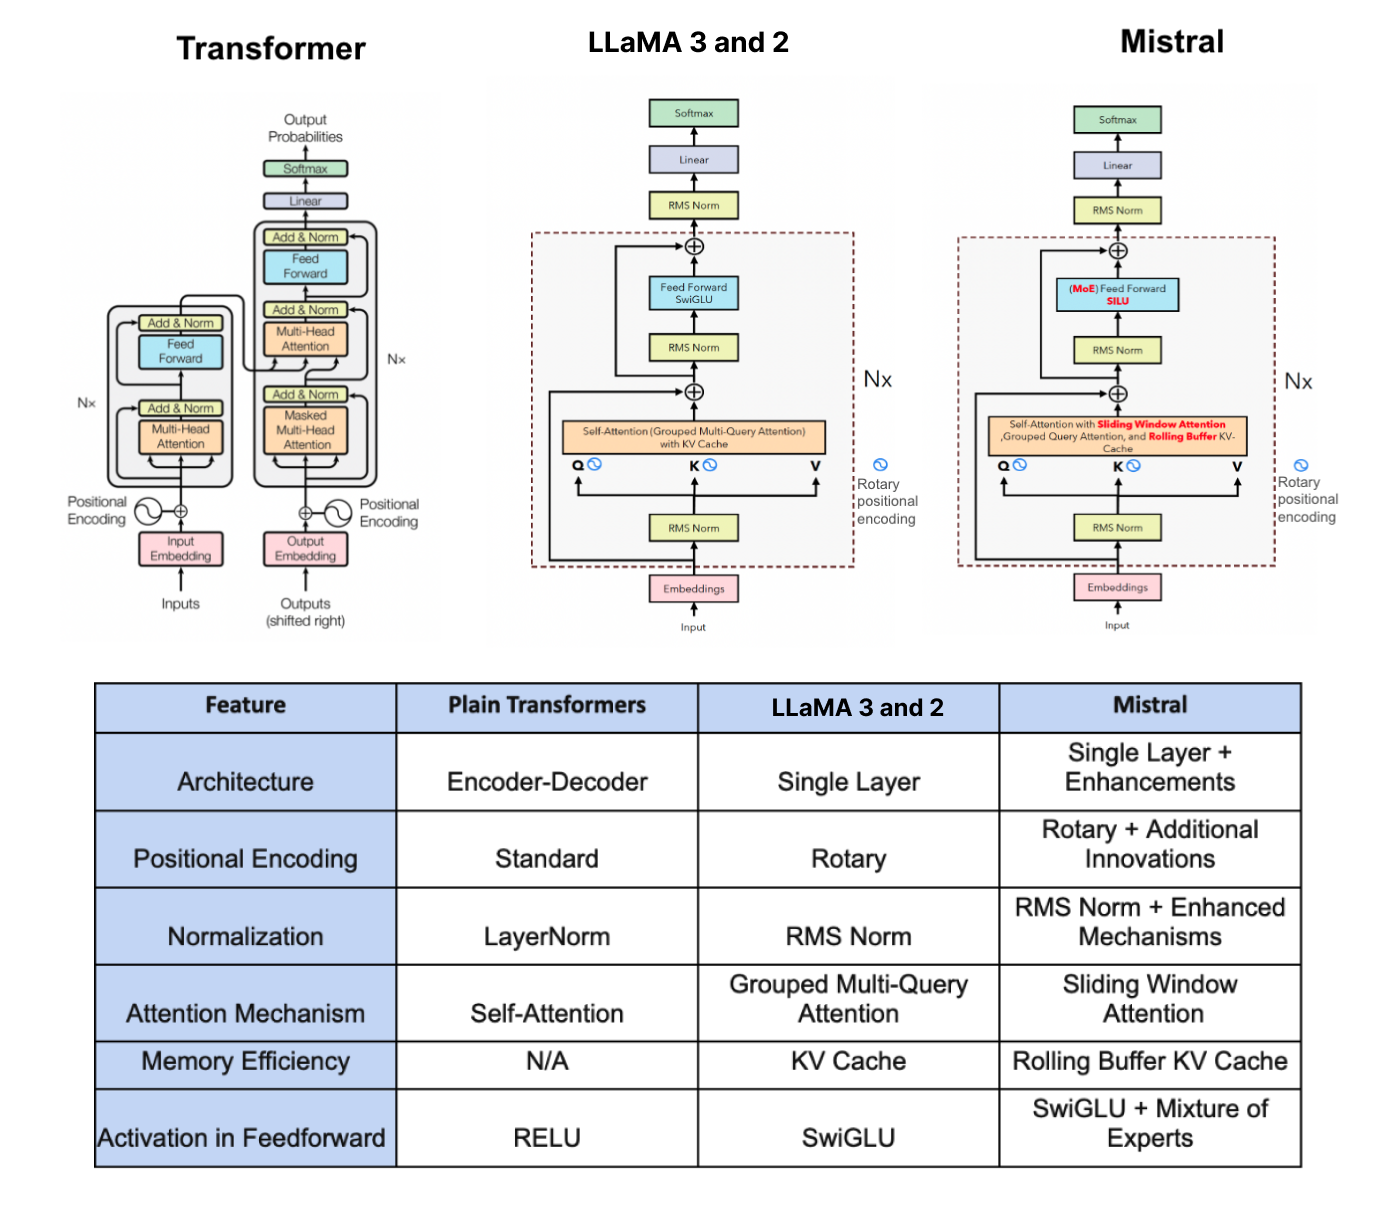

In [35]:
!pip install sentencepiece tiktoken torch blobfile matplotlib huggingface_hub

# https://lightning.ai/fareedhassankhan12/studios/building-llama-3-from-scratch?section=featured

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

After installing the required libraries, we need to download some files. Since we're going to replicate the architecture of llama-3–8B, you must have an account on HuggingFace. Additionally, since llama-3 is a gated model, you have to accept their terms and conditions to access model content.

**Here are the steps:**

Create an HuggingFace account from this Accept the terms and conditions of llama-3–8B from this

Once you've completed both of these steps, Now we have to download some files. There are two options to do that:

(Option 1: Manual) Go to the llama-3–8B HF directory from this link and manually download each of these three files.

| **Feature**                                           | **LLaMA 3**                                                 | **LLaMA 2**                                            |
| ----------------------------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------ |
| **Tokenizer**                                         | `tiktoken` (by OpenAI)                                      | `SentencePiece`                                        |
| **Number of Parameters**                              | 8B, 70B                                                     | 7B, 13B, 70B                                           |
| **Training Data**                                     | 15T tokens                                                  | 2.2T tokens                                            |
| **Context Length**                                    | 8192 tokens                                                 | 4096 tokens                                            |
| **Attention Mechanism**                               | Grouped-query attention                                     | Grouped-query attention                                |
| **Fine-Tuned Models Available**                       | Yes                                                         | Yes                                                    |
| **Performance**                                       | Outperforms LLaMA 2 on all benchmarks                       | Outperforms LLaMA 1 on most benchmarks                 |
| **Computational Requirements**                        | Very high (especially 70B)                                  | Very high (especially 70B)                             |
| **Availability**                                      | Open source                                                 | Open source                                            |
| **Reinforcement Learning from Human Feedback (RLHF)** | Yes                                                         | Yes                                                    |
| **Languages Supported**                               | 30 languages                                                | 20 languages                                           |
| **Suitable For**                                      | Most demanding tasks (reasoning, coding, proficiency tests) | Demanding tasks (reasoning, coding, proficiency tests) |


In [1]:
# Import the `notebook_login` function from the `huggingface_hub` module.
from huggingface_hub import notebook_login

# Execute the `notebook_login` function to log in to the Hugging Face Hub.
notebook_login()

 (options 2: Coding) We can use the hugging_face library, which we installed earlier, to download all of these files. However, first, we need to log in to HuggingFace Hub within our working notebook using our HF Token. You can create a new token or access it from this link.

In [2]:
# Import the necessary function from the huggingface_hub library
from huggingface_hub import hf_hub_download

# Define the repository information
repo_id = "meta-llama/Meta-Llama-3-8B"
subfolder = "original"  # Specify the subfolder within the repository

# List of filenames to download
filenames = ["params.json", "tokenizer.model", "consolidated.00.pth"]

# Specify the directory where you want to save the downloaded files
save_directory = "llama-3-8B/"  # Replace with your desired path

# Download each file
for filename in filenames:
    hf_hub_download(
        repo_id=repo_id,       # Repository ID
        filename=filename,     # Name of the file to download
        subfolder=subfolder,   # Subfolder within the repository
        local_dir=save_directory  # Directory to save the downloaded file
    )

Once all the files are downloaded, we need to import the libraries that we will be using throughout this blog.

🧠 **1. RMSNorm (Root Mean Square Layer Normalization)**

* What it is: A normalization technique used before attention and feedforward layers (pre-norm).
* Why it matters: Like assigning study weights to textbook chapters, RMSNorm scales input values based on importance, improving stability and training speed.
* Used in: LLaMA 2, LLaMA 3.
* Compared to: Standard LayerNorm used in vanilla Transformers.

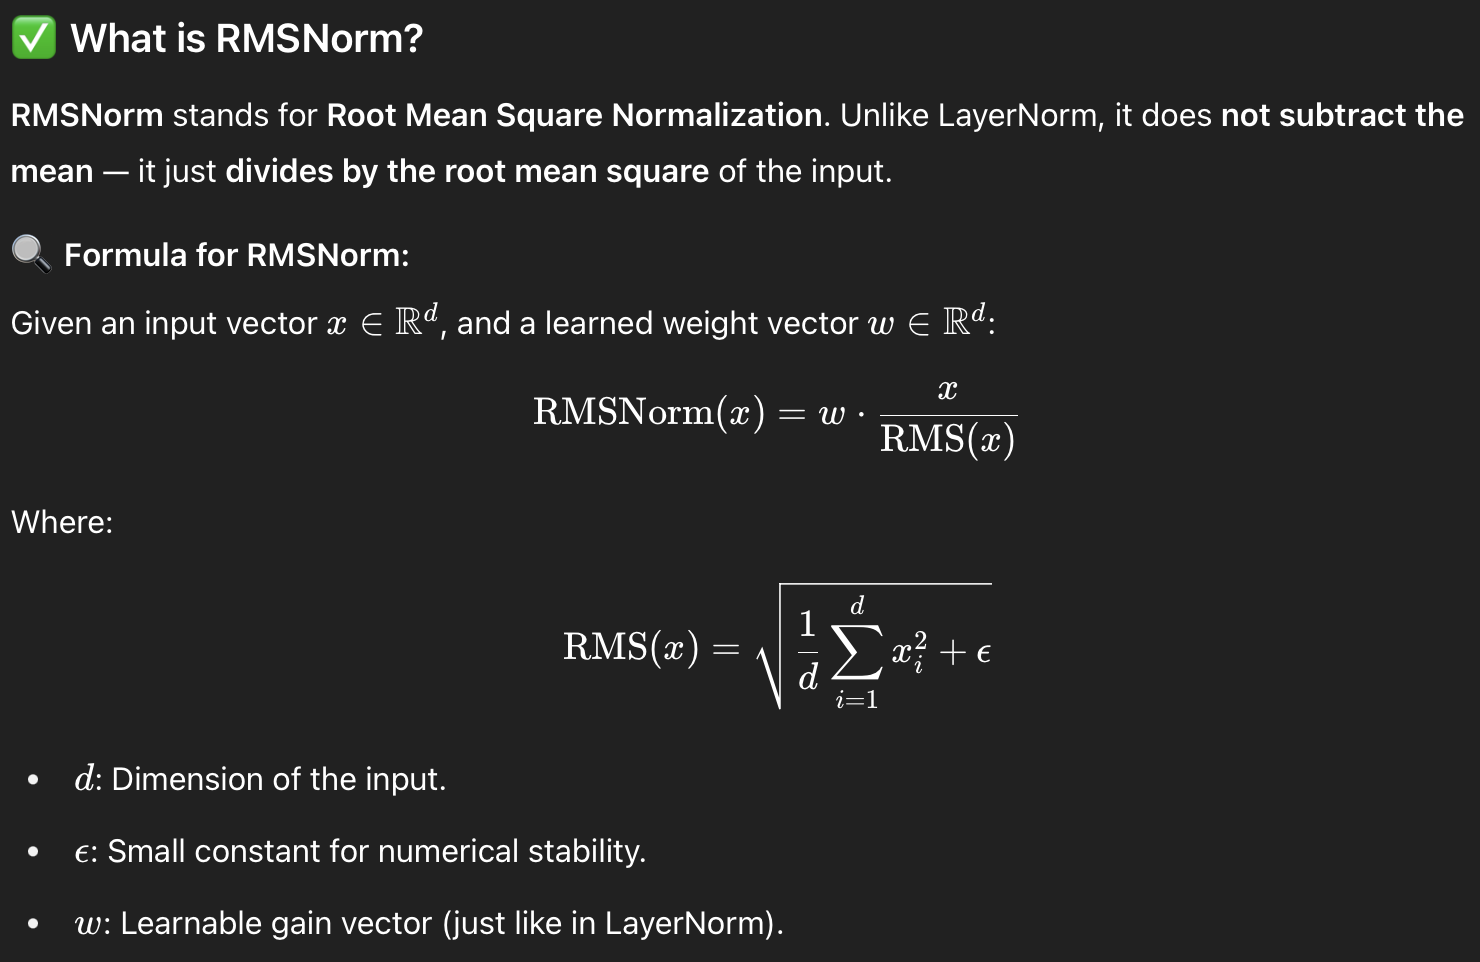
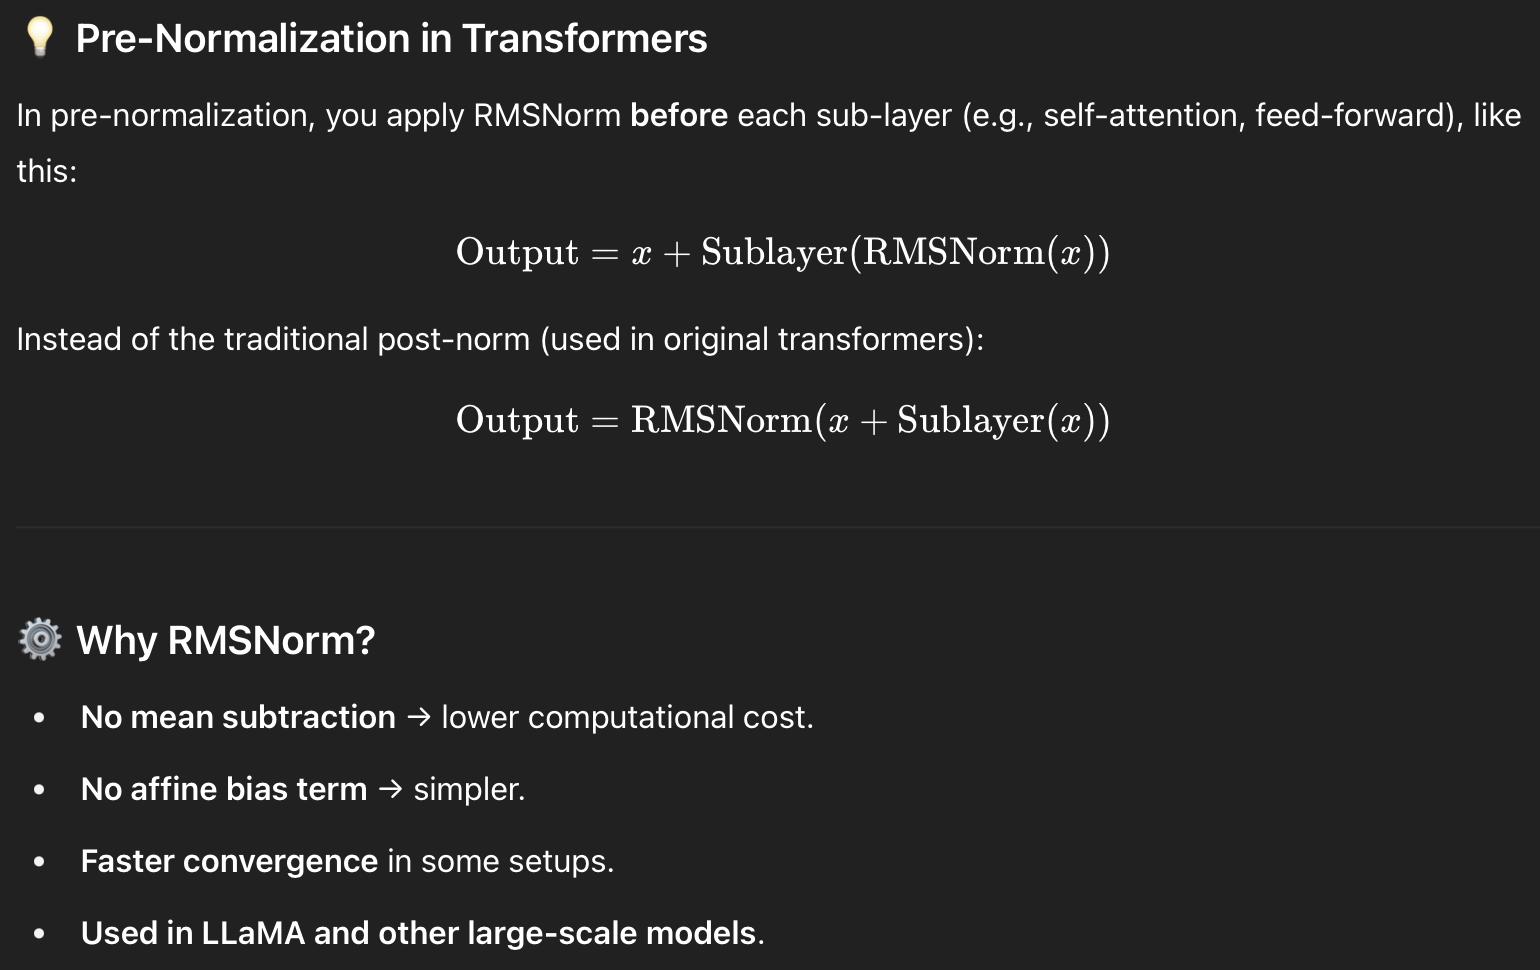

⚡ **2. SwiGLU Activation Function**

* What it is: An activation function that combines SiLU (Swish) and GLU (Gated Linear Units).
* Why it matters: Like a magic pen that emphasizes key points, SwiGLU enhances relevant features in the model’s intermediate layers, improving expressiveness and efficiency.
* Used in: LLaMA 2, LLaMA 3, and inspired by Google’s PaLM.
* Compared to: GELU in vanilla Transformers.

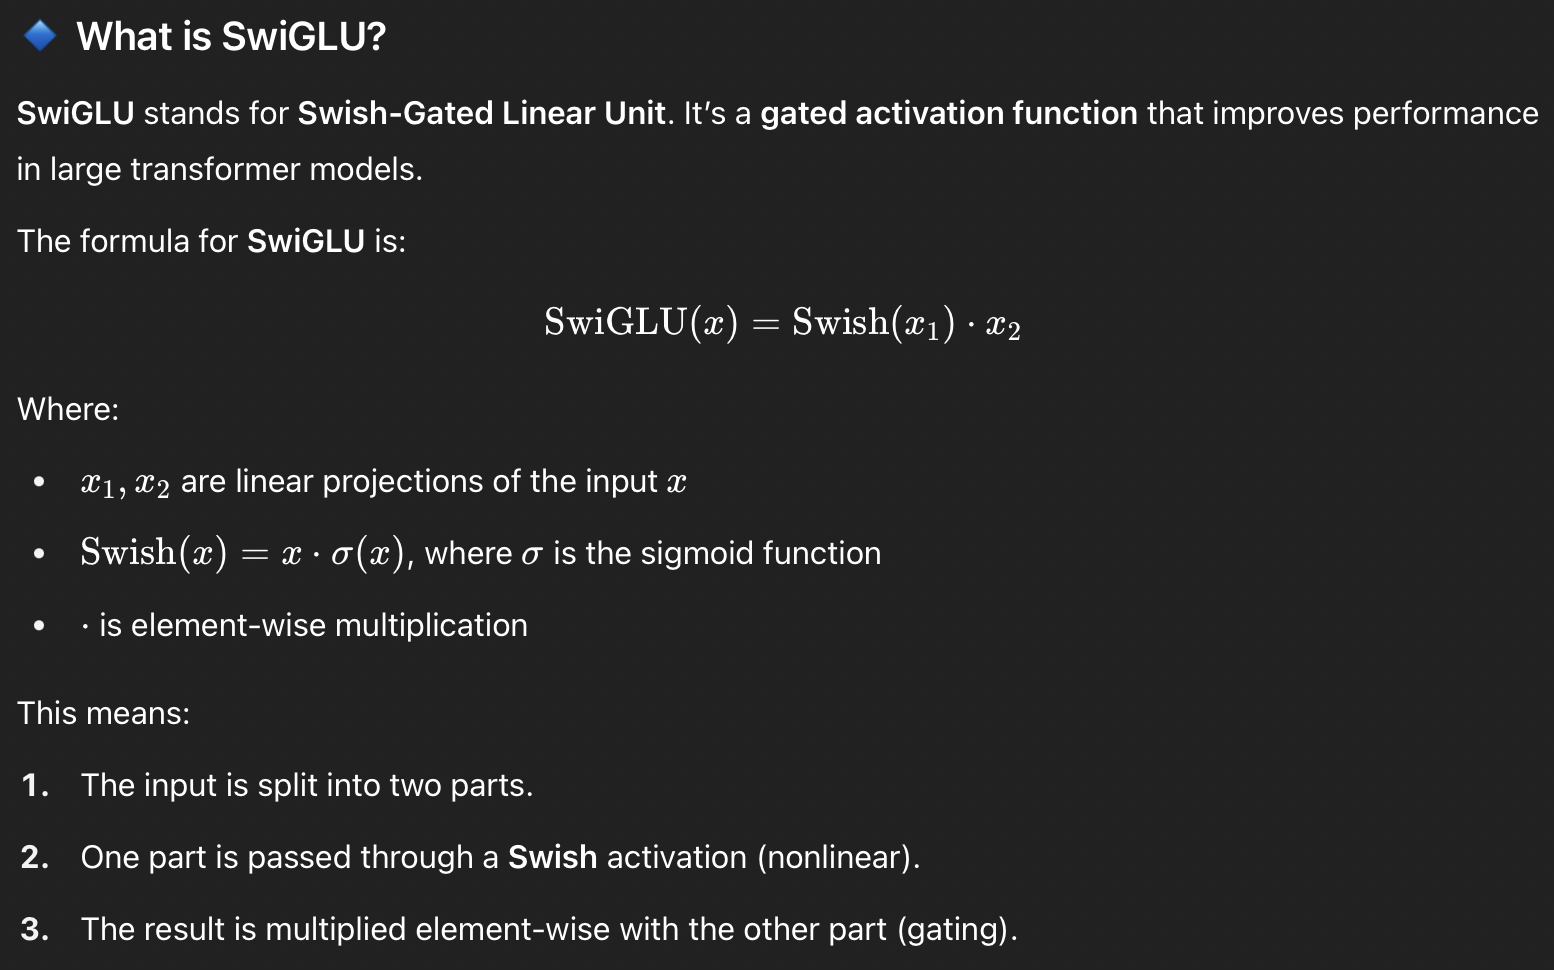

🔁 **3. RoPE (Rotary Positional Embeddings)**

* What it is: A method of encoding position by rotating embeddings in a complex space.
* Why it matters: Enables better modeling of relative positions between tokens, like dynamic seating in a classroom.Used in: LLaMA 2, LLaMA 3, Mistral.
* Compared to: Fixed absolute positional encodings in vanilla Transformers.

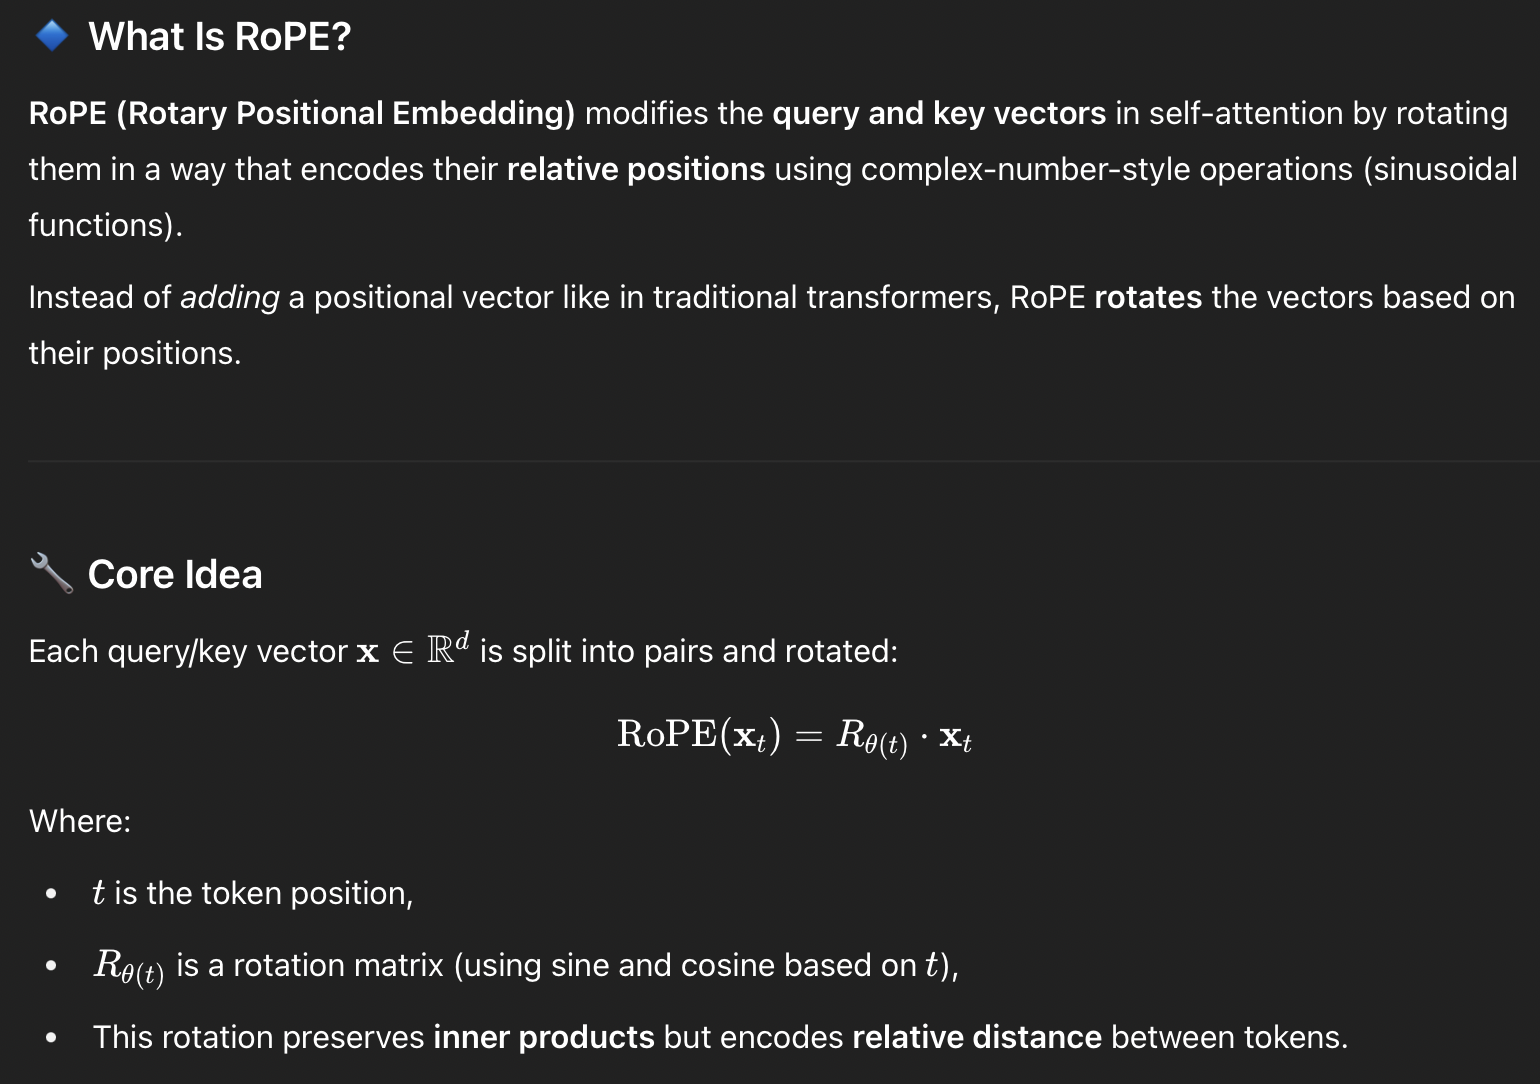
🔤 **4. Tokenizer (BPE Differences)**

* LLaMA 2: Uses SentencePiece BPE.
* LLaMA 3:Switches to OpenAI’s tiktoken BPE, similar to GPT-4's tokenizer.
* Why it matters: Slight differences in tokenization granularity and efficiency, but both aim to compress frequent subword units for faster, smaller models.


In [36]:
# File system paths
from pathlib import Path

# Tokenization library
import tiktoken

# BPE loading function
from tiktoken.load import load_tiktoken_bpe

# PyTorch library
import torch

# JSON handling
import json

# Plotting library
import matplotlib.pyplot as plt

Next, we need to understand what each file will be used for.
Since we're aiming for an exact replication of llama-3, it means our input text must yield a meaningful output. For example, if our input is "the color of the sun is?", the output must be "white". Achieving this requires training our LLM on a large dataset, which demands high computation power, making it unfeasible for us.
However, Meta has publicly released their llama-3 architecture files, or in more complex terms, their pretrained weights, for use. We've just downloaded these files, allowing us to replicate their architecture without the need for training or a large dataset. Everything is already prepared, we just have to use the right components in the right places.
Take a look at each of these files and their importance:
tokenizer.model -  As we discussed earlier, LLaMA-3 uses the Byte Pair Encoding (BPE) tokenizer from tiktoken, trained on a dataset with 15 trillion tokens - 7 times larger than the dataset used for LLaMA-2. Let's load this file and see what it holds.

In [4]:
# Loading the tokenizer from llama-3-8B
tokenizer_model = load_tiktoken_bpe("llama-3-8B/original/tokenizer.model")

# Get the length of the tokenizer model
len(tokenizer_model)
# OUTPUT: 128000

# Get the type of the `tokenizer_model` object.
type(tokenizer_model)
# OUTPUT: dictionary

dict

The length attribute shows the total vocabulary size, which is the unique number of characters in the training data. The type of tokenizer_model is a dictionary.

In [5]:
# Printing the first 10 items of tokenizer model
dict(list(tokenizer_model.items())[5600:5610])

## OUTPUT
{b'mitted': 5600,
 b" $('#": 5601,
 b' saw': 5602,
 b' approach': 5603,
 b'ICE': 5604,
 b' saying': 5605,
 b' anyone': 5606,
 b'meta': 5607,
 b'SD': 5608,
 b' song': 5609}

{b'mitted': 5600,
 b" $('#": 5601,
 b' saw': 5602,
 b' approach': 5603,
 b'ICE': 5604,
 b' saying': 5605,
 b' anyone': 5606,
 b'meta': 5607,
 b'SD': 5608,
 b' song': 5609}

When we print 10 random items from it, you will see strings that have been formed using the BPE algorithm, similar to the example we discussed earlier. Keys representing Byte sequences from BPE training, while values represent merge ranks based on frequency.

consolidated.00.pth -  contains the learned parameters (weights) of Llama-3–8B. These parameters include information about how the model understands and processes language, such as how it represents tokens, computes attention, performs feed-forward transformations, and normalizes its outputs.

In [14]:
# Loading a PyTorch model of LLaMA-3-8B
model = torch.load("llama-3-8B/original/consolidated.00.pth")

# printing first 11 layers of the architecture
list(model.keys())[:11]

## OUTPUT
['tok_embeddings.weight',
 'layers.0.attention.wq.weight',
 'layers.0.attention.wk.weight',
 'layers.0.attention.wv.weight',
 'layers.0.attention.wo.weight',
 'layers.0.feed_forward.w1.weight',
 'layers.0.feed_forward.w3.weight',
 'layers.0.feed_forward.w2.weight',
 'layers.0.attention_norm.weight',
 'layers.0.ffn_norm.weight',
 'layers.1.attention.wq.weight']

/tmp/ipykernel_51/1396191005.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("llama-3-8B/original/consolidated.00.pth")


['tok_embeddings.weight',
 'layers.0.attention.wq.weight',
 'layers.0.attention.wk.weight',
 'layers.0.attention.wv.weight',
 'layers.0.attention.wo.weight',
 'layers.0.feed_forward.w1.weight',
 'layers.0.feed_forward.w3.weight',
 'layers.0.feed_forward.w2.weight',
 'layers.0.attention_norm.weight',
 'layers.0.ffn_norm.weight',
 'layers.1.attention.wq.weight']

If you're familiar with transformer architecture, you would have known about query, key matrices, and more. Later, we will be using these layers/weights to create such matrices within the architecture of Llama-3.

params.json- contains various parameter values, such as:

In [6]:
# Opening the parameters JSON file
with open("llama-3-8B/original/params.json", "r") as f:
    config = json.load(f)

# Printing the content
print(config)

{'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': 8, 'vocab_size': 128256, 'multiple_of': 1024, 'ffn_dim_multiplier': 1.3, 'norm_eps': 1e-05, 'rope_theta': 500000.0}


These values will help us replicate the Llama-3 architecture by specifying details like the number of heads, dimension of the embedding vector and more.

Let's store these values so we can use them later.

In [15]:
# Dimension
dim = config["dim"]

# Layers
n_layers = config["n_layers"]

# Heads
n_heads = config["n_heads"]

# KV_heads
n_kv_heads = config["n_kv_heads"]

# Vocabulary
vocab_size = config["vocab_size"]

# Multiple
multiple_of = config["multiple_of"]

# Multiplier
ffn_dim_multiplier = config["ffn_dim_multiplier"]

# Epsilon
norm_eps = config["norm_eps"]

# RoPE
rope_theta = torch.tensor(config["rope_theta"])

Now that we have the tokenizer model, architecture model containing weights, and configuration parameters, let's start coding our own Llama-3 from scratch.

The very first thing we need to perform is to convert our input text to tokens, and to achieve this we first have to create some special tokens which are necessary to provide structured markers within the tokenized text, enabling the tokenizer to recognize and handle specific conditions or instructions.

In [16]:
special_tokens = [
    "<|begin_of_text|>",  # Marks the beginning of a text sequence.
    "<|end_of_text|>",  # Marks the end of a text sequence.
    "<|reserved_special_token_0|>",  # Reserved for future use.
    "<|reserved_special_token_1|>",  # Reserved for future use.
    "<|reserved_special_token_2|>",  # Reserved for future use.
    "<|reserved_special_token_3|>",  # Reserved for future use.
    "<|start_header_id|>",  # Indicates the start of a header ID.
    "<|end_header_id|>",  # Indicates the end of a header ID.
    "<|reserved_special_token_4|>",  # Reserved for future use.
    "<|eot_id|>",  # Marks the end of a turn (in a conversational context).
] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]  # A large set of tokens reserved for future use.

Next we define the rules for splitting text into tokens by specifying different patterns to match various types of substrings in the input text. Here's how we can do that.

In [17]:
# patterns based on which text will be break into tokens
tokenize_breaker = r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+"

It can extracts words, contractions, numbers (up to three digits), and sequences of non-whitespace characters from the input text, you can customize it based on your requirements. We need to code a simple tokenizer function using the TikToken BPE, which takes three inputs: tokenizer_model, tokenize_breaker, and special_tokens. This function will encode/decode our input text accordingly.

In [18]:
# Initialize tokenizer with specified parameters
tokenizer = tiktoken.Encoding(

    # make sure to set path to tokenizer.model file
    name = "/path/to/tokenizer.model",

    # Define tokenization pattern string
    pat_str = tokenize_breaker,

    # Assign BPE mergeable ranks from tokenizer_model of LLaMA-3
    mergeable_ranks = tokenizer_model,

    # Set special tokens with indices
    special_tokens={token: len(tokenizer_model) + i for i, token in enumerate(special_tokens)},
)

# Encode "hello world!" and decode tokens to string
tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

To verify that our encoder function methods work correctly, we pass "Hello World" into it. First, it encodes the text, transforming it into numerical values. Then, it decodes it back to text, resulting in "hello world!". This confirms that the function is working correctly. Let's tokenize our input.

In [19]:
# input prompt
prompt = "the answer to the ultimate question of life, the universe, and everything is "

# Encode the prompt using the tokenizer and prepend a special token (128000)
tokens = [128000] + tokenizer.encode(prompt)

print(tokens)  # Print the encoded tokens

# Convert the list of tokens into a PyTorch tensor
tokens = torch.tensor(tokens)

# Decode each token back into its corresponding string
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]

print(prompt_split_as_tokens)  # Print the decoded tokens


## OUTPUT
[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


['<|begin_of_text|>',
 'the',
 ' answer',
 ' to',
 ' the',
 ' ultimate',
 ' question',
 ' of',
 ' life',
 ',',
 ' the',
 ' universe',
 ',',
 ' and',
 ' everything',
 ' is',
 ' ']

We encoded our input text "the answer to the ultimate question of life, the universe, and everything is " starting with a special token.

If we check the length of our input vector, it would be:

In [20]:
# checking dimension of input vector and embedding vector from llama-3 architecture
print(dim, len(tokens))

## OUTPUT
# 4096 17

4096 17


Our input vectors, which are currently of dimension (17x1), need to be transformed into embeddings for each tokenized word. This means our (17x1) tokens will become (17x4096), where each token has a corresponding embedding of length 4096.

In [21]:
# Define embedding layer with vocab size and embedding dimension
embedding_layer = torch.nn.Embedding(vocab_size, dim)

# Copy pre-trained token embeddings to the embedding layer
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

# Get token embeddings for given tokens, converting to torch.bfloat16 format
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)

# Print shape of resulting token embeddings
token_embeddings_unnormalized.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

These embeddings are not normalized, and it will have a serious effect if we don’t normalize them. In the next section, we will perform normalization on our input vectors.

We will normalize the input vectors using the same formula we have seen earlier for RMSNorm to ensure our inputs are normalized.

In [22]:
# Calculating RMSNorm
def rms_norm(tensor, norm_weights):

    # Calculate the mean of the square of tensor values along the last dimension
    squared_mean = tensor.pow(2).mean(-1, keepdim=True)

    # Add a small value to avoid division by zero
    normalized = torch.rsqrt(squared_mean + norm_eps)

    # Multiply normalized tensor by the provided normalization weights
    return (tensor * normalized) * norm_weights

We will use the attention weights from layers_0 to normalize our unnormalized embeddings. The reason for using layer_0 is that we are now creating the first layer of our LLaMA-3 transformer architecture.

In [23]:
# using RMS normalization and provided normalization weights
token_embeddings = rms_norm(token_embeddings_unnormalized,
                            model["layers.0.attention_norm.weight"])

# Print the shape of the resulting token embeddings
token_embeddings.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

You may already know that the dimension won’t change because we are only normalizing the vectors and nothing else.

first, let’s load the query, key, value and output vectors from the model.

In [24]:
# Print the shapes of different weights
print(
    # Query weight shape
    model["layers.0.attention.wq.weight"].shape,

    # Key weight shape
    model["layers.0.attention.wk.weight"].shape,

    # Value weight shape
    model["layers.0.attention.wv.weight"].shape,

    # Output weight shape
    model["layers.0.attention.wo.weight"].shape
)


#### OUTPUT ####
torch.Size([4096, 4096]) # Query weight dimension
torch.Size([1024, 4096]) # Key weight dimension
torch.Size([1024, 4096]) # Value weight dimension
torch.Size([4096, 4096]) # Output weight dimension
#### OUTPUT ####

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


torch.Size([4096, 4096])

The dimensions indicate that the model weights we downloaded are not for each head individually but for multiple attention heads due to implementing a parallel approach/training. However, we can unwrap these matrices to make them available for a single head only.

In [25]:
# Retrieve query weight for the first layer of attention
q_layer0 = model["layers.0.attention.wq.weight"]

# Calculate dimension per head
head_dim = q_layer0.shape[0] // n_heads

# Reshape query weight to separate heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)

# Print the shape of the reshaped query weight tensor
q_layer0.shape


#### OUTPUT ####
torch.Size([32, 128, 4096])
#### OUTPUT ####

torch.Size([32, 128, 4096])

Here, 32 is the number of attention heads in Llama-3, 128 is the size of the query vector, and 4096 is the size of the token embedding.

We can access the query weight matrix of the first head of the first layer using:

In [26]:
# Extract the query weight for the first head of the first layer of attention
q_layer0_head0 = q_layer0[0]

# Print the shape of the extracted query weight tensor for the first head
q_layer0_head0.shape


#### OUTPUT ####
torch.Size([128, 4096])
#### OUTPUT ####

torch.Size([128, 4096])

In [27]:
# Matrix multiplication: token embeddings with transpose of query weight for first head
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)

# Shape of resulting tensor: queries per token
q_per_token.shape


#### OUTPUT ####
torch.Size([17, 128])
#### OUTPUT ####

torch.Size([17, 128])

The query vectors don’t inherently know their position in the prompt, so we’ll use RoPE to make them aware of it.

We split the query vectors into pairs and then apply a rotational angle shift to each pair.

In [30]:
# Convert queries per token to float and split into pairs
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)

# Print the shape of the resulting tensor after splitting into pairs
q_per_token_split_into_pairs.shape


#### OUTPUT ####
torch.Size([17, 64, 2])
#### OUTPUT ####

torch.Size([17, 64, 2])

We have a vector of size [17x64x2], which represents the 128-length queries split into 64 pairs for each token in the prompt. Each pair will be rotated by m*theta, where m is the position of the token for which we are rotating the query.

We’ll use the dot product of complex numbers to rotate a vector.

In [38]:
# Generate values from 0 to 1 split into 64 parts
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64

# Print the resulting tensor
zero_to_one_split_into_64_parts


#### OUTPUT ####
torch.tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])
#### OUTPUT ####

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [40]:
# Calculate frequencies using a power operation
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)

# Display the resulting frequencies
freqs


#### OUTPUT ####
torch.tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])
#### OUTPUT ####

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

Now, with a complex number for each token’s query element, we convert our queries into complex numbers and then rotate them based on their position using dot product.

In [41]:
# Convert queries per token to complex numbers
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)

q_per_token_as_complex_numbers.shape
# Output: torch.Size([17, 64])

# Calculate frequencies for each token using outer product of arange(17) and freqs
freqs_for_each_token = torch.outer(torch.arange(17), freqs)

# Calculate complex numbers from frequencies_for_each_token using polar coordinates
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)

# Rotate complex numbers by frequencies
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis

q_per_token_as_complex_numbers_rotated.shape
# Output: torch.Size([17, 64])

torch.Size([17, 64])

After obtaining the rotated vector, we can revert back to our original queries as pairs by viewing the complex numbers as real numbers again.

In [42]:
# Convert rotated complex numbers back to real numbers
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)

# Print the shape of the resulting tensor
q_per_token_split_into_pairs_rotated.shape


#### OUTPUT ####
torch.Size([17, 64, 2])
#### OUTPUT ####

torch.Size([17, 64, 2])

The rotated pairs are now merged, resulting in a new query vector (rotated query vector) that has the shape [17x128], where 17 is the number of tokens and 128 is the dimension of the query vector.

In [43]:
# Reshape rotated token queries to match the original shape
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

# Print the shape of the resulting tensor
q_per_token_rotated.shape


#### OUTPUT ####
torch.Size([17, 128])
#### OUTPUT ####

torch.Size([17, 128])

For keys, the process is similar, but keep in mind that key vectors are also 128-dimensional. Keys have only 1/4th the number of weights as queries because they are shared across 4 heads at a time to minimize computations. Keys are also rotated to include positional information, similar to queries.

In [44]:
# Extract the weight tensor for the attention mechanism's key in the first layer of the model
k_layer0 = model["layers.0.attention.wk.weight"]

# Reshape key weight for the first layer of attention to separate heads
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)

# Print the shape of the reshaped key weight tensor
k_layer0.shape  # Output: torch.Size([8, 128, 4096])

# Extract the key weight for the first head of the first layer of attention
k_layer0_head0 = k_layer0[0]

# Print the shape of the extracted key weight tensor for the first head
k_layer0_head0.shape  # Output: torch.Size([128, 4096])

# Calculate key per token by matrix multiplication
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)

# Print the shape of the resulting tensor representing keys per token
k_per_token.shape  # Output: torch.Size([17, 128])

# Split key per token into pairs and convert to float
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)

# Print the shape of the resulting tensor after splitting into pairs
k_per_token_split_into_pairs.shape  # Output: torch.Size([17, 64, 2])

# Convert key per token to complex numbers
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)

# Print the shape of the resulting tensor representing key per token as complex numbers
k_per_token_as_complex_numbers.shape  # Output: torch.Size([17, 64])

# Rotate complex key per token by frequencies
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)

# Print the shape of the rotated complex key per token
k_per_token_split_into_pairs_rotated.shape  # Output: torch.Size([17, 64, 2])

# Reshape rotated key per token to match the original shape
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

# Print the shape of the rotated key per token
k_per_token_rotated.shape  # Output: torch.Size([17, 128])

torch.Size([17, 128])

We now have the rotated queries and keys for each token, with each being of size [17x128].
Multiplying the query and key matrices will give us a score that maps each token to another. This score indicates the relationship between each token’s query and key.

In [45]:
# Calculate query-key dot products per token
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (head_dim) ** 0.5

# Print the shape of the resulting tensor representing query-key dot products per token
qk_per_token.shape


#### OUTPUT ####
torch.Size([17, 17])
#### OUTPUT ####

torch.Size([17, 17])

[17x17] Shape represents attention score (qk_per_token) where 17 is the number of tokens in the prompt.

We need to mask the query-key scores. During training, future token query-key scores are masked because we only learn to predict tokens using past tokens. As a result, during inference, we set the future tokens to zero.

In [48]:
# # Create a mask tensor filled with negative infinity values
# mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)

# # Set upper triangular part of the mask tensor to negative infinity
# mask = torch.triu(mask, diagonal=1)

# # Print the resulting mask tensor
# mask


# #### OUTPUT ####
# torch.tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
#         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
# #### OUTPUT ####
import torch

# Assuming `tokens` is a tensor of shape (seq_len,)
seq_len = len(tokens)

# Create a square matrix filled with -inf
mask = torch.full((seq_len, seq_len), float('-inf'), device=tokens.device)

# Set lower triangle (including diagonal) to 0 (i.e., allow attending to self and past tokens)
mask = torch.triu(mask, diagonal=1)

# Optional: convert to float32 for consistency
mask = mask.to(torch.float32)

print(mask)



tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

Now, we have to apply a mask to the query-key per token vector. Additionally, we want to apply softmax on top of it to convert the output scores into probabilities. This helps in selecting the most likely token or sequence of tokens from the model’s vocabulary, making the model’s predictions more interpretable and suitable for tasks like language generation and classification.

In [49]:
# Add the mask to the query-key dot products per token
qk_per_token_after_masking = qk_per_token + mask

# Apply softmax along the second dimension after masking
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

For the value matrix, which marks the end of the self-attention part, similar to keys, value weights are also shared across every 4 attention heads to save computation. As a result, the shape of the value weight matrix is [8x128x4096].

In [50]:
# Retrieve the value weight for the first layer of attention
v_layer0 = model["layers.0.attention.wv.weight"]

# Reshape value weight for the first layer of attention to separate heads
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)

# Print the shape of the reshaped value weight tensor
v_layer0.shape


#### OUTPUT ####
torch.Size([8, 128, 4096])
#### OUTPUT ####

torch.Size([8, 128, 4096])

Similar to the query and key matrices, the value matrix for the first layer and first head can be obtained using:

In [51]:
# Extract the value weight for the first head of the first layer of attention
v_layer0_head0 = v_layer0[0]

# Print the shape of the extracted value weight tensor for the first head
v_layer0_head0.shape


#### OUTPUT ####
torch.Size([128, 4096])
#### OUTPUT ####

torch.Size([128, 4096])

Using the value weights, we compute the attention values for each token, resulting in a matrix of size [17x128]. Here, 17 denotes the number of tokens in the prompt, and 128 indicates the dimension of the value vector for each token.

In [52]:
# Calculate value per token by matrix multiplication
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)

# Print the shape of the resulting tensor representing values per token
v_per_token.shape


#### OUTPUT ####
torch.Size([17, 128])
#### OUTPUT ####

torch.Size([17, 128])

In [53]:
# Calculate QKV attention by matrix multiplication
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

# Print the shape of the resulting tensor
qkv_attention.shape


#### OUTPUT ####
torch.Size([17, 128])
#### OUTPUT ####

torch.Size([17, 128])

We now have the attention values for the first layer and first head or in other words self attention.

A loop will be executed to perform the same calculations as above, but for every head in the first layer.

In [54]:
# Store QKV attention for each head in a list
qkv_attention_store = []

# Iterate through each head
for head in range(n_heads):
    # Extract query, key, and value weights for the current head
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4]  # Key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4]  # Value weights are shared across 4 heads

    # Calculate query per token by matrix multiplication
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)

    # Calculate key per token by matrix multiplication
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)

    # Calculate value per token by matrix multiplication
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    # Split query per token into pairs and rotate them
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    # Split key per token into pairs and rotate them
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    # Calculate query-key dot products per token
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (128) ** 0.5

    # Create a mask tensor filled with negative infinity values
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    # Set upper triangular part of the mask tensor to negative infinity
    mask = torch.triu(mask, diagonal=1)
    # Add the mask to the query-key dot products per token
    qk_per_token_after_masking = qk_per_token + mask

    # Apply softmax along the second dimension after masking
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

    # Calculate QKV attention by matrix multiplication
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

    # Store QKV attention for the current head
    qkv_attention_store.append(qkv_attention)

# Print the number of QKV attentions stored
len(qkv_attention_store)


#### OUTPUT ####
32
#### OUTPUT ####

32

Now that the QKV attention matrix for all 32 heads in the first layer is obtained, all attention scores will be merged into one large matrix of size [17x4096].

In [55]:
# Concatenate QKV attentions from all heads along the last dimension
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

# Print the shape of the resulting tensor
stacked_qkv_attention.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

One of the last steps for layer 0 attention is to multiply the weight matrix with the stacked QKV matrix.

In [56]:
# Calculate the embedding delta by matrix multiplication with the output weight
embedding_delta = torch.matmul(stacked_qkv_attention, model["layers.0.attention.wo.weight"].T)

# Print the shape of the resulting tensor
embedding_delta.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

We now have the change in the embedding values after attention, which should be added to the original token embeddings.

In [57]:
# Add the embedding delta to the unnormalized token embeddings to get the final embeddings
embedding_after_edit = token_embeddings_unnormalized + embedding_delta

# Print the shape of the resulting tensor
embedding_after_edit.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

The change in embeddings is normalized, followed by running it through a feedforward neural network.

In [58]:
# Normalize edited embeddings using root mean square normalization and provided weights
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])

# Print the shape of resulting normalized embeddings
embedding_after_edit_normalized.shape

#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

Given our familiarity with the SwiGLU activation function from the previous section, we will apply the equation we studied earlier here.

In [59]:
# Retrieve weights for feedforward layer
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]

# Perform operations for feedforward layer
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)

# Print the shape of the resulting tensor after feedforward
output_after_feedforward.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

In [62]:
# Initialize final embedding with unnormalized token embeddings
final_embedding = token_embeddings_unnormalized

# Iterate through each layer
for layer in range(n_layers):
    # Initialize list to store QKV attentions for each head
    qkv_attention_store = []

    # Normalize the final embedding using root mean square normalization and weights from the current layer
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])

    # Retrieve query, key, value, and output weights for the attention mechanism of the current layer
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]

    # Iterate through each head
    for head in range(n_heads):
        # Extract query, key, and value weights for the current head
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]  # Key weights are shared across 4 heads
        v_layer_head = v_layer[head//4]  # Value weights are shared across 4 heads

        # Calculate query per token by matrix multiplication
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)

        # Calculate key per token by matrix multiplication
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)

        # Calculate value per token by matrix multiplication
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

        # Split query per token into pairs and rotate them
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

        # Split key per token into pairs and rotate them
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

        # Calculate query-key dot products per token
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (128) ** 0.5

        # Create a mask tensor filled with negative infinity values
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        # Set upper triangular part of the mask tensor to negative infinity
        mask = torch.triu(mask, diagonal=1)
        # Add the mask to the query-key dot products per token
        qk_per_token_after_masking = qk_per_token + mask

        # Apply softmax along the second dimension after masking
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

        # Calculate QKV attention by matrix multiplication
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

        # Store QKV attention for the current head
        qkv_attention_store.append(qkv_attention)

    # Concatenate QKV attentions from all heads along the last dimension
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

    # Calculate embedding delta by matrix multiplication with the output weight
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)

    # Add the embedding delta to the current embedding to get the edited embedding
    embedding_after_edit = final_embedding + embedding_delta

    # Normalize the edited embedding using root mean square normalization and weights from the current layer
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])

    # Retrieve weights for the feedforward layer
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]

    # Perform operations for the feedforward layer
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)

    # Update the final embedding with the edited embedding plus the output from the feedforward layer
    final_embedding = embedding_after_edit + output_after_feedforward

We now have the final embedding, representing the model’s guess for the next token. Its shape is the same as regular token embeddings, [17x4096], with 17 tokens and an embedding dimension of 4096.

In [63]:
# Normalize the final embedding using root mean square normalization and provided weights
final_embedding = rms_norm(final_embedding, model["norm.weight"])

# Print the shape of the resulting normalized final embedding
final_embedding.shape


#### OUTPUT ####
torch.Size([17, 4096])
#### OUTPUT ####

torch.Size([17, 4096])

In [64]:
# Print the shape of the output weight tensor
model["output.weight"].shape


#### OUTPUT ####
torch.Size([128256, 4096])
#### OUTPUT ####

torch.Size([128256, 4096])

To predict the next value, we utilize the embedding of the last token.

In [65]:
# Calculate logits by matrix multiplication between the final embedding and the transpose of the output weight tensor
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)

# Print the shape of the resulting logits tensor
logits.shape


#### OUTPUT ####
torch.Size([128256])
#### OUTPUT ####

torch.Size([128256])

In [67]:
# Find the index of the maximum value along the last dimension to determine the next token
next_token = torch.argmax(logits, dim=-1)

# Output the index of the next token
next_token

#### OUTPUT ####
torch.tensor(2983)
#### OUTPUT ####

tensor(2983)

In [68]:
# Decode the index of the next token using the tokenizer
tokenizer.decode([next_token.item()])


#### OUTPUT ####
42
#### OUTPUT ####

42


So, our input was “the answer to the ultimate question of life, the universe, and everything is ”, and the output for it is “42”, which is the correct answer.

You can experiment with different input texts by simply changing these two lines throughout the entire code, Rest of the code remains same!

In [77]:
# input prompt
prompt = "This is my first LLama model implementation so let's test it out"

# Replacing 17 number with total number of tokens in your input
# You can check total number of tokens using len(tokens)
freqs_for_each_token = torch.outer(torch.arange(5), freqs)

In [78]:
# freqs_for_each_token